Here is an example of loading up the baseline simualtion and returning information about the visits that overlap a single point in the sky.

Installation instructions for rubin_sim can be found in the documentation at https://rubin-sim.lsst.io

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import healpy as hp

import rubin_sim.maf as maf
import rubin_scheduler.utils as rsUtils
from rubin_sim.data import get_baseline

In [2]:
# Grab the current baseline file. Should have been downloaded with rubin_sim. 
# Can grab lots of different sims from: http://astro-lsst-01.astro.washington.edu:8081/
baseline_file = get_baseline()
name = os.path.basename(baseline_file).replace('.db','')
out_dir = 'temp'
results_db = maf.db.ResultsDb(out_dir=out_dir)

In [3]:
bundle_list = []
# The point on the sky we would like to get visits for
ra = [0.]
dec = [-20]


# Say we just want to pass data through, not compute anything. Documentation on 
# columns at:  https://rubin-sim.lsst.io/rs_scheduler/output_schema.html
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth', 'visitExposureTime'])
# Select all the visits. Could be something like "filter='r'", "night < 365", etc
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))

In [4]:
bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()


In [5]:
# Our bundleList now has values. The trailing [0] is to get the first result. If we specified more
# ra,dec point, those results would be in the later indices.
bundle_list[0].metric_values[0][0:10]

rec.array([(-21.42128256, 'r', 29.2,  64.00720723, 63116.27693368, 23.53031103, 358.71939525),
           (-21.49880768, 'g', 29.2, -27.48244901, 62054.22326649, 24.41581775, 359.78251728),
           (-21.71164698, 'y', 29.2,  -6.34293366, 61010.05224098, 22.52065804, 359.30774856),
           (-21.49880768, 'r', 29.2, -27.48244901, 62054.2478585 , 24.13246669, 359.78251728),
           (-21.71950325, 'r', 29.2, 113.61021229, 62408.04995462, 23.7429872 , 359.93492375),
           (-21.82442172, 'r', 29.2,  80.06640325, 63203.09269582, 23.94427842, 359.44280175),
           (-21.82442172, 'g', 29.2,  80.06640325, 63203.06767668, 24.83139143, 359.44280175),
           (-21.58930803, 'z', 15. , -37.40712766, 63625.03234893, 20.98643196, 359.91908182),
           (-21.71950325, 'g', 29.2, 113.43080089, 62408.02586921, 23.76727639, 359.93492375),
           (-21.64615389, 'r', 29.2, 110.65304651, 62330.2570165 , 24.06308624, 359.97580572)],
          dtype=[('fieldDec', '<f8'), ('filter', 

Text(0.5, 1.0, 'baseline_v4.3.1_10yrs\nObservations at ra=0.000, dec=-20.000')

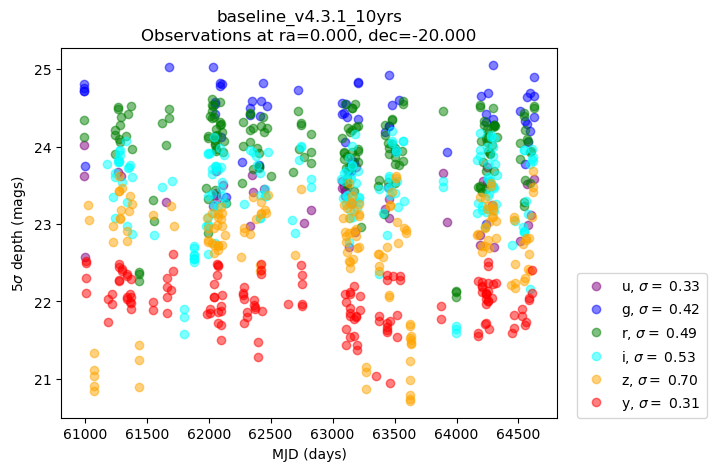

In [6]:
# As a bit of foreshadowing for how the rest of MAF works, we'll call the visits overlapping a
# single point in the sky "dataSlice". 
data_slice = bundle_list[0].metric_values[0]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    plt.plot(data_slice['observationStartMJD'][in_filt],
             data_slice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', $\sigma=$ %.2f' % (np.std(data_slice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))

Text(0, 0.5, 'Cummulative Number of Visits')

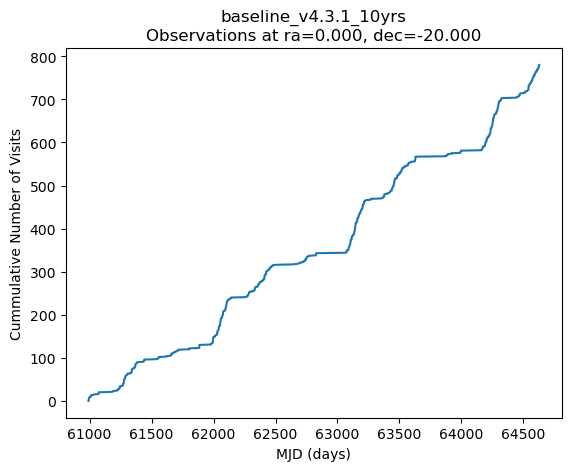

In [7]:
n_vis = np.arange(data_slice['observationStartMJD'].size)
mjd = np.sort(data_slice['observationStartMJD'])
plt.plot(mjd, n_vis)
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))
plt.xlabel('MJD (days)')
plt.ylabel("Cummulative Number of Visits")

Text(0.5, 1.0, 'baseline_v4.3.1_10yrs\nObservations at ra=0.000, dec=-20.000')

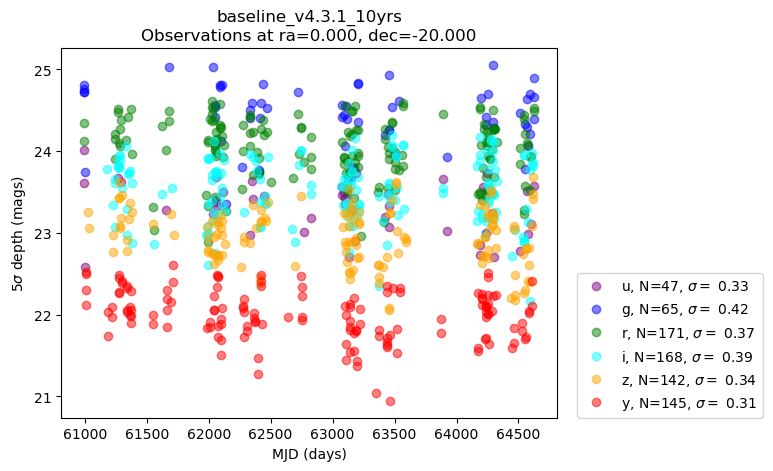

In [8]:
# Note there are some odd low-depth outliers. Those are probably the 1x15s
# twilight time exposures. let's try filtering those out

data_slice = bundle_list[0].metric_values[0]

# crop off short exposure times
data_slice = data_slice[np.where(data_slice["visitExposureTime"] > 25.)]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    plt.plot(data_slice['observationStartMJD'][in_filt],
             data_slice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', N=%i, $\sigma=$ %.2f' % (np.size(in_filt), np.std(data_slice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))

Text(0.5, 1.0, 'baseline_v4.3.1_10yrs\nObservations at ra=0.000, dec=-20.000')

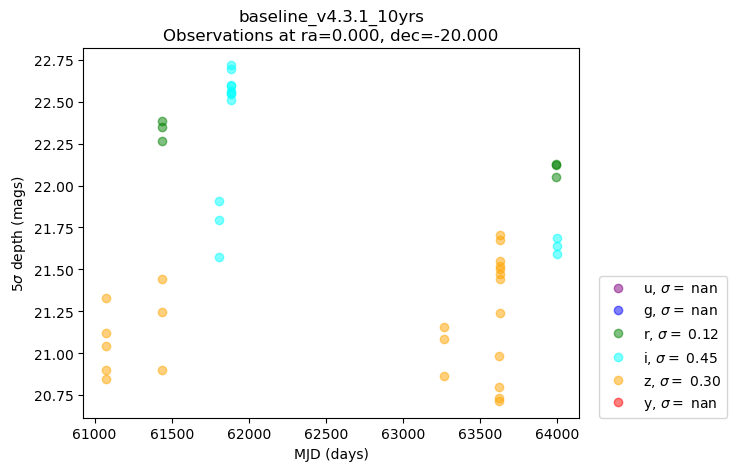

In [9]:
# and now looking only at short exposure times

data_slice = bundle_list[0].metric_values[0]

# Include only short exposures
data_slice = data_slice[np.where(data_slice["visitExposureTime"] < 25.)]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    plt.plot(data_slice['observationStartMJD'][in_filt],
             data_slice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', $\sigma=$ %.2f' % (np.std(data_slice['fiveSigmaDepth'][in_filt])),
             alpha=0.5)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))

Let's try out doing it on a DDF location

In [10]:
bundle_list = []
# The point on the sky we would like to get visits for
ra = [9.450]
dec = [-44.0]


# Say we just want to pass data through, not compute anything. Documentation on 
# columns at:  https://rubin-sim.lsst.io/rs_scheduler/output_schema.html
metric = maf.metrics.PassMetric(cols=['filter', 'observationStartMJD', 'fiveSigmaDepth', 'visitExposureTime'])
# Select all the visits. Could be something like "filter='r'", "night < 365", etc
sql = ''
slicer = maf.slicers.UserPointsSlicer(ra=ra, dec=dec)
bundle_list.append(maf.MetricBundle(metric, slicer, sql, run_name=name))

bd = maf.metricBundles.make_bundles_dict_from_list(bundle_list)
bg = maf.metricBundles.MetricBundleGroup(bd, baseline_file, out_dir=out_dir, results_db=results_db)
bg.run_all()



Text(0.5, 1.0, 'baseline_v4.3.1_10yrs\nObservations at ra=9.450, dec=-44.000')

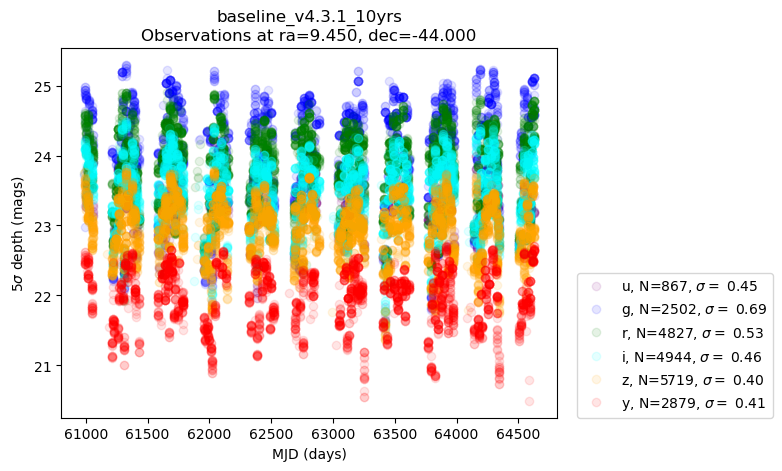

In [11]:
data_slice = bundle_list[0].metric_values[0]

# crop off short exposure times
data_slice = data_slice[np.where(data_slice["visitExposureTime"] > 25.)]

# Let's plot up what the 5-sigma depth looks like
plt.figure()
# Give each filter it's own color
f2c = {'u': 'purple', 'g': 'blue', 'r': 'green',
       'i': 'cyan', 'z': 'orange', 'y': 'red'}
for fn in f2c:
    in_filt = np.where(data_slice['filter'] == fn)[0]
    plt.plot(data_slice['observationStartMJD'][in_filt],
             data_slice['fiveSigmaDepth'][in_filt], 'o',
             color=f2c[fn],
             label=fn+r', N=%i, $\sigma=$ %.2f' % (np.size(in_filt), np.std(data_slice['fiveSigmaDepth'][in_filt])),
             alpha=0.1)
plt.xlabel('MJD (days)')
plt.ylabel(r'5$\sigma$ depth (mags)')
plt.legend(loc=(1.04,0))
plt.title('%s\nObservations at ra=%.3f, dec=%.3f' % (name, ra[0],dec[0]))